
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [32]:

import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
from fgbuster.cosmology import _get_Cl_cmb
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import healpy as hp
import numdifftools as nd
import math as m

In [33]:
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)

In [26]:
nside = 64
freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)
print(freq_maps.shape)

(22, 3, 49152)


In [34]:
components= [CMB(), Dust(50.), Synchrotron(50.)]

In [35]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
#invN=np.linalg.inv(np.eye(len(instrument.frequency)))
invN = np.diag((hp.nside2resol(nside, arcmin=True) / instrument.depth_p)**2)

In [36]:

x1 = np.array([1.3,19,-2.5, 0.8,1.3])
 

(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
(2, 49152)
392578164.59193444
5.047042128512234e-05


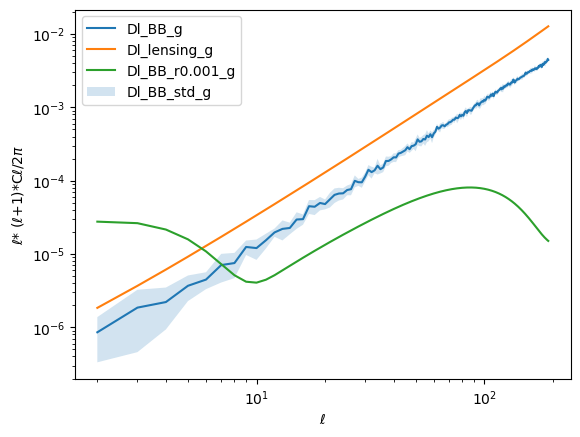

In [37]:
Cl_all_g = []
seeds = 10
for i in range (seeds):
    np.random.seed(i)
    freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
    #here it will become (22,2,49152)
    

    def spectral_likelihood(y):
        Bd, T, Bs, a, c = y
        b = 1
        G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])
        invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
        A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
        logL = 0
        AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
        AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
        logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
        if logL != logL:
            return 0.0
        return -logL

    min_= minimize (spectral_likelihood, x1, method='Nelder-Mead')
  
 
    a = min_.x[3]
    b= 1
    c = min_.x[4]
    G = np.diag([a,a,a,a,a,a,a,b,b,b,b,b,b,b,b,c,c,c,c,c,c,c])  
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(min_.x)) 

    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))


    s = np.einsum('cg,gsp->csp', AtNA,AtNd)
    s = s[0]
    print(s.shape) # It is (2,49152).... this is the reason why I am adding zeros with shape (1,49152)
    zeros=np.zeros((1, 49152))
    unione = np.vstack((zeros, s))
    
    
    Cl =hp.anafast(unione)[2,2:]
    Cl_all_g.append(Cl)
 

Cl_all_g=np.array(Cl_all_g)
Cl_mean_g=np.mean(Cl_all_g, axis=0) 
Cl_std_g = np.std(Cl_all_g, axis=0)



ell = np.arange(2,192)
Dl_mean_g = (ell*(ell+1)*Cl_mean_g)/(2*m.pi)
Dl_std_g = (ell*(ell+1)*Cl_std_g)/(2*m.pi)




Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
Cl_BB_r001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB_r001)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)

Data_g = Cl_mean_g + Cl_lens
fsky = 1
F_g = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data_g ** 2)
sigma_r_fisher_g = np.sqrt(1.0 / F_g)
print(F_g)
print(sigma_r_fisher_g)





plt.loglog(ell, Dl_mean_g, label = "Dl_BB_g")
plt.loglog(ell, Dl_lens, label = "Dl_lensing_g")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001_g")
plt.fill_between(ell,Dl_mean_g+Dl_std_g, Dl_mean_g-Dl_std_g, alpha=0.2, label="Dl_BB_std_g")



plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()


Now I want to do the same using the averaged likelihood, where I don't need to do the cicle for 10 noise realization (right?).
In this I avoid the choice to do that:
freq_maps = get_observation(instrument, 'd0s0', noise=True, nside=nside)[:,1:,:]
using all the freq_maps..  
If I did this I have some dimensions problems in the part where I add the "zeros" again.  


In [30]:
dati = np.einsum('ijp,klm-> ik',freq_maps,freq_maps)
print(dati.shape)


(22, 22)


(22,)
456136457.1373986
4.682228536295863e-05


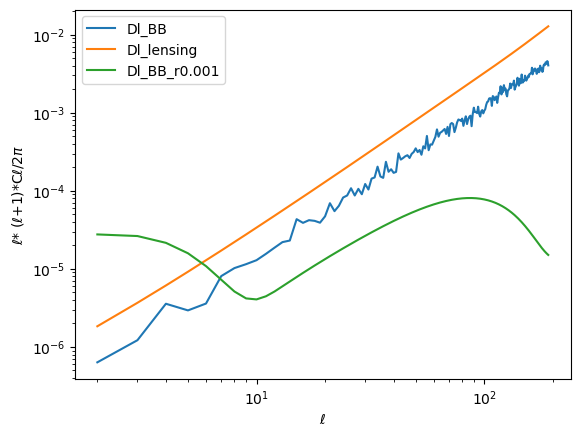

In [42]:

def aver_likelihood(y):
        Bd, T, Bs, a, c = y
        b= 1
        G = np.diag([a, a, a, a, a, a, a, a, b, b, b, b, b, b, c, c, c, c, c, c, c, c ])
        A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
        logL = 0
        AtN = A_maxL.T.dot(invN)
        NA= invN.dot(A_maxL)
        AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
        logL = logL + np.trace(AtNA.dot(AtN).dot(dati).dot(NA))
        if logL != logL:
            return 0.0
        return logL

    

min_= minimize (aver_likelihood, x1, method='Nelder-Mead')
   
    
    
   
A_maxL =A_ev(min_.x) 
AtN = A_maxL.T.dot(invN)
AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
s = AtNA.dot(AtN).dot(dati)
s = s[0]
print(s.shape)

#the shape of s[0] is 22, not (2,49152) as before
    
#no adding of the zeros part, I keep all the freq_maps   
# zeros=np.zeros((1, 49152))
# unione = np.vstack((zeros, s))
        
   
    
Cl =hp.anafast(unione)[2,2:]   
 


ell = np.arange(2,192)
Dl_mean = (ell*(ell+1)*Cl)/(2*m.pi)



Cl_BB_r1 = _get_Cl_cmb(Alens=0.0, r=1.)[2][2:192]
Cl_BB_r_001 = _get_Cl_cmb(Alens=0.0, r=0.001)[2][2:192]
Dl_BB = (ell*(ell+1)*Cl_BB_r_001)/(2*m.pi)

Cl_lens = _get_Cl_cmb(Alens=1.0, r=0.)[2][2:192]
Dl_lens = (ell*(ell+1)*Cl_lens)/(2*m.pi)


Data = Cl + Cl_lens
fsky = 1
F = np.sum((2*ell+1) * fsky / 2*Cl_BB_r1** 2 / Data ** 2)
sigma_r_fisher = np.sqrt(1.0 / F)
print(F)
print(sigma_r_fisher)



plt.loglog(ell, Dl_mean, label = "Dl_BB")
plt.loglog(ell, Dl_lens, label = "Dl_lensing")
plt.loglog(ell, Dl_BB, label = "Dl_BB_r0.001")




plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell$* ($\ell$+1)*C$\ell$/2$\pi$')
plt.legend()



    
